In [3]:
import json
import os
from pathlib import Path
import random
import shutil

# Paths to your TACO dataset
coco_json_path = 'annotations.json'  # Path to TACO's annotations file
images_dir = 'data'                  # Path to TACO's main image directory with batch subfolders
output_dir = 'yolo_taco_recycling'   # Base directory for YOLO format

# Train, validation, test split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Ensure output directories for train, val, and test sets
for split in ['train', 'val', 'test']:
    Path(output_dir, split, 'images').mkdir(parents=True, exist_ok=True)
    Path(output_dir, split, 'labels').mkdir(parents=True, exist_ok=True)

# Load TACO annotations
with open(coco_json_path, 'r') as f:
    data = json.load(f)

# Get category mappings
categories = {category['id']: category['name'] for category in data['categories']}

# Shuffle images for random split
images = data['images']
random.shuffle(images)
n_train = int(len(images) * train_ratio)
n_val = int(len(images) * val_ratio)

# Split images into train, val, test
splits = {
    'train': images[:n_train],
    'val': images[n_train:n_train + n_val],
    'test': images[n_train + n_val:]
}

# Counter for the total number of images moved
total_images_moved = 0

# Convert annotations and save them into respective split folders
for split, split_images in splits.items():
    for img in split_images:
        img_id = img['id']
        img_file_name = img['file_name']  # This should be in the format 'batch_x/filename.jpg'
        img_width, img_height = img['width'], img['height']
        
        # Derive the image path within one of the 15 batch folders
        img_path = os.path.join(images_dir, img_file_name)
        img_name = img_file_name.split('/')[-1]  # Get the image filename only
        
        # Copy image to the corresponding split folder
        split_image_path = os.path.join(output_dir, split, 'images', img_name)
        if os.path.exists(img_path):
            shutil.copy(img_path, split_image_path)
            total_images_moved += 1  # Increment the counter

            # Create a corresponding label file for each image
            label_file_path = os.path.join(output_dir, split, 'labels', os.path.splitext(img_name)[0] + '.txt')
            with open(label_file_path, 'w') as label_file:
                # Find all annotations for the current image
                for ann in data['annotations']:
                    if ann['image_id'] == img_id:
                        category_id = ann['category_id']
                        # Ensure the category is in our mapping
                        if category_id in categories:
                            # YOLO format requires x_center, y_center, width, and height normalized
                            x, y, width, height = ann['bbox']
                            x_center = (x + width / 2) / img_width
                            y_center = (y + height / 2) / img_height
                            width /= img_width
                            height /= img_height

                            # Write the label file in YOLO format: <class_id> <x_center> <y_center> <width> <height>
                            label_file.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

# Print the total number of images moved
print(f"Total number of images moved: {total_images_moved}")

Total number of images moved: 0


In [14]:
import os

# Base path to the YOLO-structured dataset
base_path = 'yolo_taco_recycling'  # Update this to your dataset's root directory

# Define paths for each split
splits = ['train', 'val', 'test']

# Updated mapping of TACO class IDs to new IDs for recyclable materials, excluding under represented classes
recyclable_class_mapping = {
    0: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 10: 7,
    13: 8, 15: 9, 16: 10, 17: 11, 20: 12, 
    26: 13, 28: 14, 33: 15, 34: 16, 36: 17, 
    40: 18, 41: 19, 42: 20, 43: 21, 44: 22, 45: 23, 
    46: 24, 47: 25, 49: 26
}

# Process each split directory (train, val, test)
for split in splits:
    label_dir = os.path.join(base_path, split, 'labels')
    
    # Process each label file in the current split
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_dir, label_file)
            
            # Read original label data
            with open(label_path, 'r') as file:
                lines = file.readlines()
            
            # Filter and remap lines
            new_lines = []
            for line in lines:
                parts = line.strip().split()
                original_class_id = int(parts[0])
                
                # Check if the class is in the updated recyclable mapping
                if original_class_id in recyclable_class_mapping:
                    # Get the new class ID
                    new_class_id = recyclable_class_mapping[original_class_id]
                    
                    # Keep the bounding box information as it is and replace the class ID
                    new_line = f"{new_class_id} " + " ".join(parts[1:]) + "\n"
                    new_lines.append(new_line)
            
            # Save the updated labels to the same file in the split directory
            with open(label_path, 'w') as file:
                file.writelines(new_lines)

print("Filtered and remapped label files saved for each split.")

Filtered and remapped label files saved for each split.


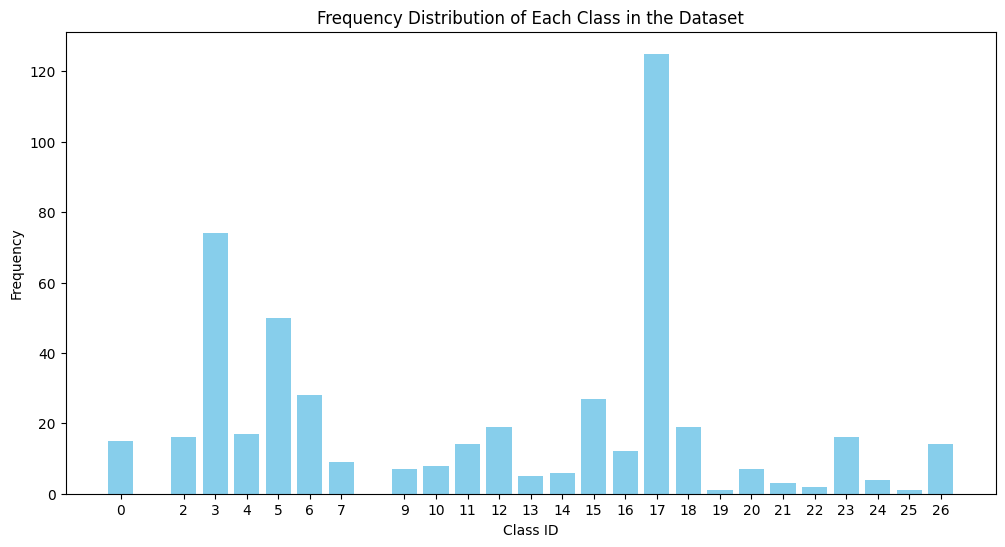

In [15]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Paths to the directories containing label files
base_dir = 'yolo_taco_recycling'  # Update this path to your dataset's base directory
label_dirs = [os.path.join(base_dir, split, 'labels') for split in ['train', 'val', 'test']]

# Initialize a counter for class frequencies
class_counts = Counter()

# Traverse each label directory (train, val, test)
for label_dir in label_dirs:
    if os.path.exists(label_dir):
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                label_path = os.path.join(label_dir, label_file)
                
                # Read the label file and count each class ID
                with open(label_path, 'r') as file:
                    for line in file:
                        class_id = int(line.split()[0])  # Get the class ID (first element in each line)
                        class_counts[class_id] += 1

# Sort the class counts by class ID for plotting
class_ids, frequencies = zip(*sorted(class_counts.items()))

# Plot the frequency distribution
plt.figure(figsize=(12, 6))
plt.bar(class_ids, frequencies, color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Each Class in the Dataset')
plt.xticks(class_ids)  # Show all class IDs on the x-axis
plt.show()

In [17]:
import os
from collections import Counter
from prettytable import PrettyTable

# Define the base directory and label directories
base_dir = 'yolo_taco_recycling'  # Update this path to your dataset's base directory
label_dirs = [os.path.join(base_dir, split, 'labels') for split in ['train', 'val', 'test']]

# Define the mapping of class IDs to category names
category_names = {
    0: "Aluminium foil", 1: "Carded blister pack", 2: "Other plastic bottle", 3: "Clear plastic bottle",
    4: "Glass bottle", 5: "Plastic bottle cap", 6: "Metal bottle cap", 7: "Food can",
    8: "Toilet tube", 9: "Egg carton", 10: "Drink carton", 11: "Corrugated carton",
    12: "Paper cup", 13: "Glass jar", 14: "Metal lid", 15: "Normal paper",
    16: "Paper bag", 17: "Plastic film", 18: "Single-use carrier bag", 19: "Polypropylene bag",
    20: "Crisp packet", 21: "Spread tub", 22: "Tupperware", 23: "Disposable food container",
    24: "Foam food container", 25: "Other plastic container", 26: "Plastic utensils"
}

# Initialize a counter for class frequencies
class_counts = Counter()

# Traverse each label directory (train, val, test)
for label_dir in label_dirs:
    if os.path.exists(label_dir):
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                label_path = os.path.join(label_dir, label_file)
                
                # Read the label file and count each class ID
                with open(label_path, 'r') as file:
                    for line in file:
                        class_id = int(line.split()[0])  # Get the class ID (first element in each line)
                        class_counts[class_id] += 1

# Create a PrettyTable for displaying the results in a table format
table = PrettyTable()
table.field_names = ["Category Name", "Number of Instances"]

# Add rows to the table for each category
for class_id, count in class_counts.items():
    category_name = category_names.get(class_id, f"Unknown ID {class_id}")
    table.add_row([category_name, count])

# Print the table
print(table)

+---------------------------+---------------------+
|       Category Name       | Number of Instances |
+---------------------------+---------------------+
|      Plastic utensils     |          14         |
|   Single-use carrier bag  |          19         |
|     Plastic bottle cap    |          50         |
|    Clear plastic bottle   |          74         |
|          Food can         |          9          |
|         Glass jar         |          5          |
|         Metal lid         |          6          |
|       Aluminium foil      |          15         |
|    Other plastic bottle   |          16         |
|         Spread tub        |          3          |
|        Plastic film       |         125         |
|         Paper cup         |          19         |
|        Drink carton       |          8          |
|        Glass bottle       |          17         |
| Disposable food container |          16         |
|      Metal bottle cap     |          28         |
|        Cri

In [18]:
import os
import random
import shutil
from pathlib import Path
from collections import Counter

# Define paths to the dataset
base_dir = 'yolo_taco_recycling'  # Update this path to your dataset's base directory
label_dirs = [os.path.join(base_dir, split, 'labels') for split in ['train', 'val', 'test']]
image_dirs = [os.path.join(base_dir, split, 'images') for split in ['train', 'val', 'test']]

# Define a target count for balancing each class
target_count = 50

# Initialize a counter for class frequencies
class_counts = Counter()

# Traverse each label directory (train, val, test) to get current class counts
file_paths = []  # To store file paths for balancing later
for label_dir, image_dir in zip(label_dirs, image_dirs):
    if os.path.exists(label_dir):
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                label_path = os.path.join(label_dir, label_file)
                image_path = os.path.join(image_dir, label_file.replace('.txt', '.jpg'))
                
                # Collect file paths
                file_paths.append((label_path, image_path))
                
                # Count each class in the label file
                with open(label_path, 'r') as file:
                    for line in file:
                        class_id = int(line.split()[0])  # Get the class ID (first element in each line)
                        class_counts[class_id] += 1

# Identify underrepresented classes
underrepresented_classes = {class_id: count for class_id, count in class_counts.items() if count < target_count}

# Print underrepresented classes for verification
print("Underrepresented classes before balancing:", underrepresented_classes)

# Duplicate files to balance classes
for class_id, count in underrepresented_classes.items():
    needed = target_count - count  # How many more instances we need
    # Filter label files that contain this class
    relevant_files = [(label, image) for label, image in file_paths if any(int(line.split()[0]) == class_id for line in open(label))]
    
    for _ in range(needed):
        # Randomly select a file containing the class to duplicate
        label_path, image_path = random.choice(relevant_files)
        # Define new file names
        label_dir, label_file = os.path.split(label_path)
        image_dir, image_file = os.path.split(image_path)
        
        new_label_file = f"{Path(label_file).stem}_dup_{random.randint(1000, 9999)}.txt"
        new_image_file = f"{Path(image_file).stem}_dup_{random.randint(1000, 9999)}.jpg"
        
        new_label_path = os.path.join(label_dir, new_label_file)
        new_image_path = os.path.join(image_dir, new_image_file)
        
        # Copy the label and image file to create duplicates
        shutil.copy(label_path, new_label_path)
        shutil.copy(image_path, new_image_path)

# Verify the new distribution
new_class_counts = Counter()
for label_dir in label_dirs:
    if os.path.exists(label_dir):
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                label_path = os.path.join(label_dir, label_file)
                with open(label_path, 'r') as file:
                    for line in file:
                        class_id = int(line.split()[0])
                        new_class_counts[class_id] += 1

print("Class distribution after balancing:")
for class_id, count in new_class_counts.items():
    print(f"Class {class_id}: {count} instances")


Underrepresented classes before balancing: {26: 14, 18: 19, 7: 9, 13: 5, 14: 6, 0: 15, 2: 16, 21: 3, 12: 19, 10: 8, 4: 17, 23: 16, 6: 28, 20: 7, 15: 27, 16: 12, 11: 14, 24: 4, 25: 1, 22: 2, 9: 7, 19: 1}
Class distribution after balancing:
Class 23: 97 instances
Class 25: 72 instances
Class 22: 98 instances
Class 21: 65 instances
Class 26: 67 instances
Class 24: 70 instances
Class 17: 301 instances
Class 11: 93 instances
Class 18: 146 instances
Class 5: 150 instances
Class 0: 82 instances
Class 3: 244 instances
Class 7: 176 instances
Class 13: 143 instances
Class 14: 165 instances
Class 4: 70 instances
Class 12: 95 instances
Class 20: 53 instances
Class 15: 126 instances
Class 6: 108 instances
Class 16: 77 instances
Class 2: 80 instances
Class 10: 78 instances
Class 9: 206 instances
Class 19: 56 instances


In [19]:
import os
from collections import Counter
from prettytable import PrettyTable

# Define the base directory and label directories
base_dir = 'yolo_taco_recycling'  # Update this path to your dataset's base directory
label_dirs = [os.path.join(base_dir, split, 'labels') for split in ['train', 'val', 'test']]

# Define the mapping of class IDs to category names
category_names = {
    0: "Aluminium foil", 1: "Carded blister pack", 2: "Other plastic bottle", 3: "Clear plastic bottle",
    4: "Glass bottle", 5: "Plastic bottle cap", 6: "Metal bottle cap", 7: "Food can",
    8: "Toilet tube", 9: "Egg carton", 10: "Drink carton", 11: "Corrugated carton",
    12: "Paper cup", 13: "Glass jar", 14: "Metal lid", 15: "Normal paper",
    16: "Paper bag", 17: "Plastic film", 18: "Single-use carrier bag", 19: "Polypropylene bag",
    20: "Crisp packet", 21: "Spread tub", 22: "Tupperware", 23: "Disposable food container",
    24: "Foam food container", 25: "Other plastic container", 26: "Plastic utensils"
}

# Initialize a counter for class frequencies
class_counts = Counter()

# Traverse each label directory (train, val, test)
for label_dir in label_dirs:
    if os.path.exists(label_dir):
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                label_path = os.path.join(label_dir, label_file)
                
                # Read the label file and count each class ID
                with open(label_path, 'r') as file:
                    for line in file:
                        class_id = int(line.split()[0])  # Get the class ID (first element in each line)
                        class_counts[class_id] += 1

# Create a PrettyTable for displaying the results in a table format
table = PrettyTable()
table.field_names = ["Category Name", "Number of Instances"]

# Add rows to the table for each category
for class_id, count in class_counts.items():
    category_name = category_names.get(class_id, f"Unknown ID {class_id}")
    table.add_row([category_name, count])

# Print the table
print(table)

+---------------------------+---------------------+
|       Category Name       | Number of Instances |
+---------------------------+---------------------+
| Disposable food container |          97         |
|  Other plastic container  |          72         |
|         Tupperware        |          98         |
|         Spread tub        |          65         |
|      Plastic utensils     |          67         |
|    Foam food container    |          70         |
|        Plastic film       |         301         |
|     Corrugated carton     |          93         |
|   Single-use carrier bag  |         146         |
|     Plastic bottle cap    |         150         |
|       Aluminium foil      |          82         |
|    Clear plastic bottle   |         244         |
|          Food can         |         176         |
|         Glass jar         |         143         |
|         Metal lid         |         165         |
|        Glass bottle       |          70         |
|         Pa

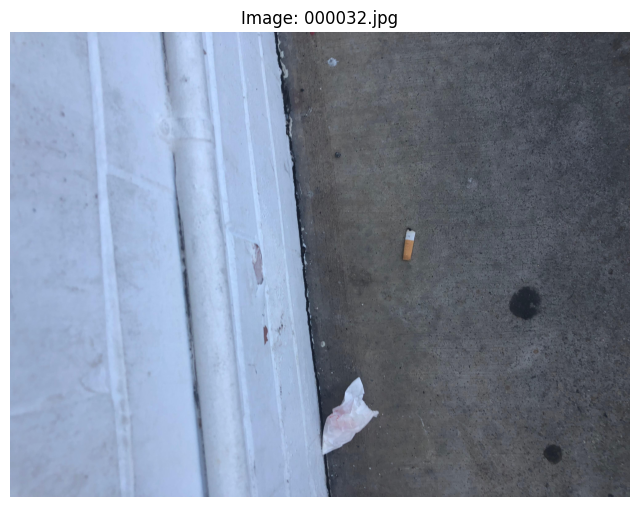

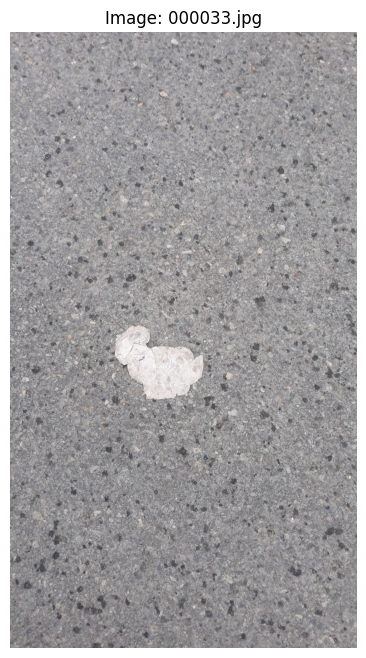

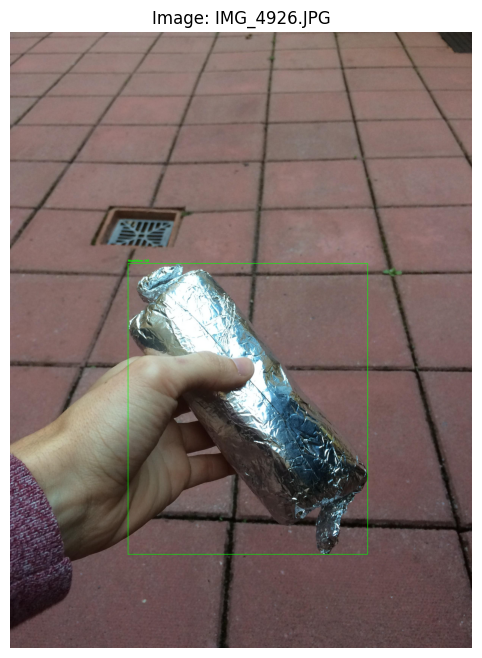

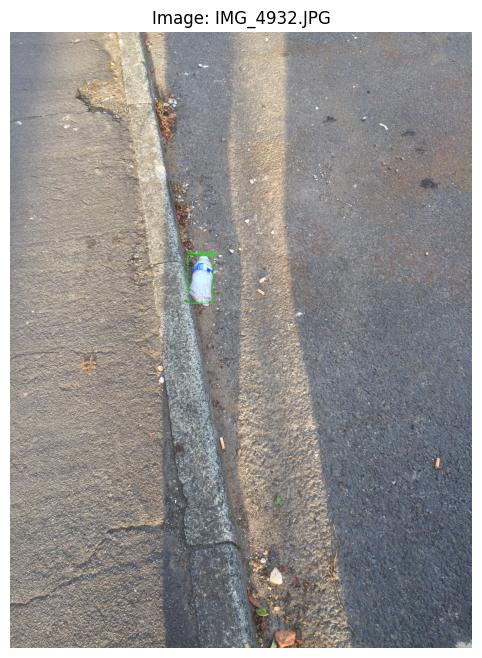

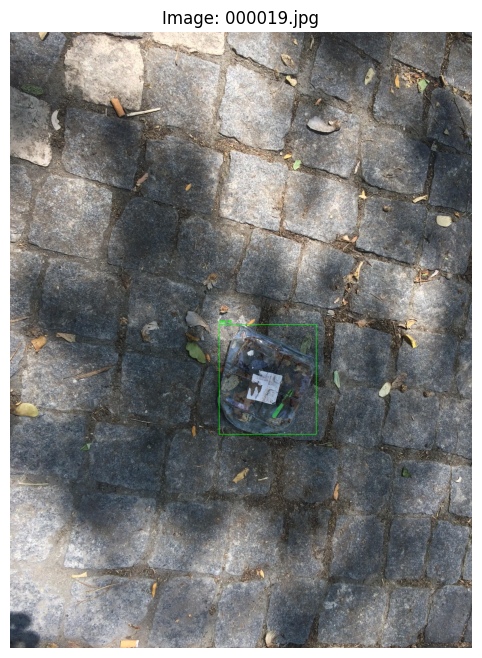

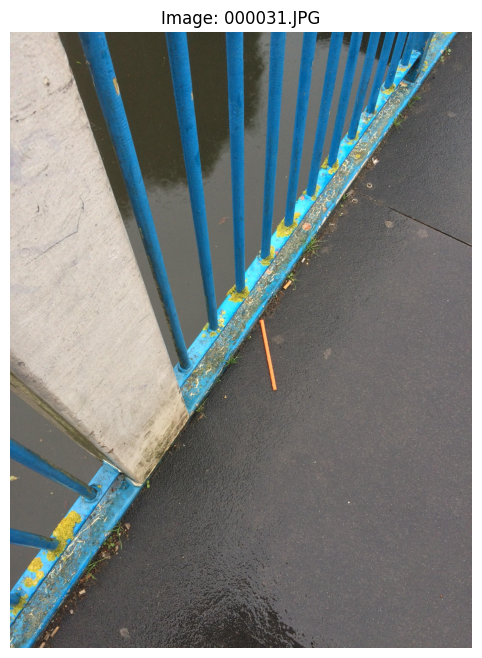

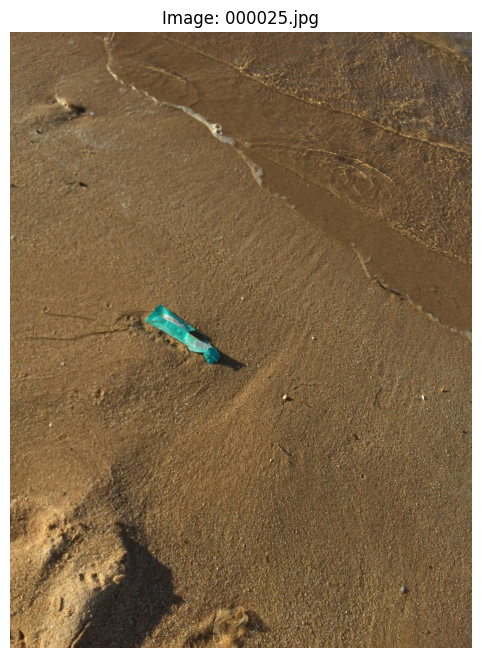

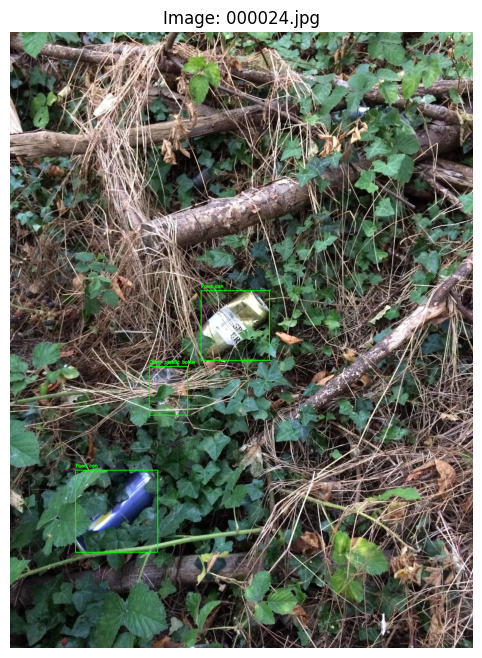

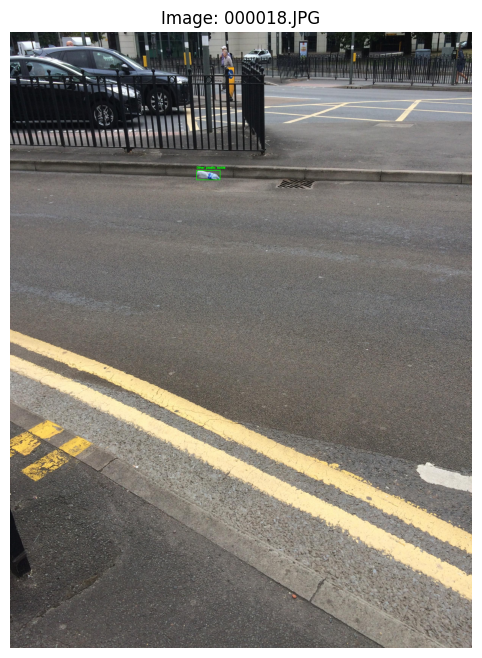

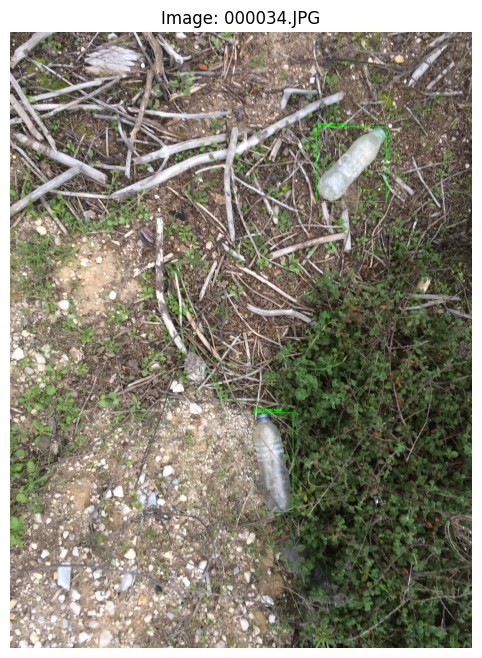

In [20]:
%matplotlib inline
import cv2
import os
import matplotlib.pyplot as plt

def plot_bounding_boxes(image_dir, label_dir, class_names, max_images=10):
    # Get a list of all image files in the image directory
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.JPG', '.png', '.jpeg', '.jpg'))]
    
    # Counter to keep track of number of images displayed
    count = 0
    
    for image_file in image_files:
        if count >= max_images:
            break  # Stop after displaying max_images
        
        # Load the image
        img_path = os.path.join(image_dir, image_file)
        img = cv2.imread(img_path)
        img_height, img_width = img.shape[:2]
        
        # Load the corresponding YOLO label file
        label_file = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
        
        # Check if the label file exists
        if os.path.exists(label_file):
            with open(label_file, 'r') as file:
                for line in file.readlines():
                    parts = line.strip().split()
                    
                    # Parse YOLO format values
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    # Convert YOLO format to bounding box format (x_min, y_min, x_max, y_max)
                    x_min = int((x_center - width / 2) * img_width)
                    y_min = int((y_center - height / 2) * img_height)
                    x_max = int((x_center + width / 2) * img_width)
                    y_max = int((y_center + height / 2) * img_height)
                    
                    # Draw the bounding box and label on the image
                    color = (0, 255, 0)  # Green color for bounding box
                    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
                    label = f"{class_names[class_id]}"
                    img = cv2.putText(img, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
            # Display the image with bounding boxes
            plt.figure(figsize=(8, 8))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Image: {image_file}")
            plt.axis('off')
            plt.show()
            
            count += 1  # Increment the counter after displaying an image
        else:
            print(f"No label file found for image: {image_file}")

# Directory paths
image_dir = 'yolo_taco/test/images'    
label_dir = 'yolo_taco/test/labels'   

# Updated recyclable materials list (aligned with new class mapping)
recyclable_class_names = [
    "Aluminium foil", "Carded blister pack", "Other plastic bottle", "Clear plastic bottle",
    "Glass bottle", "Plastic bottle cap", "Metal bottle cap", "Food can", "Toilet tube",
    "Egg carton", "Drink carton", "Corrugated carton", "Paper cup", "Glass jar",
    "Metal lid", "Normal paper", "Paper bag", "Plastic film", "Single-use carrier bag",
    "Polypropylene bag", "Crisp packet", "Spread tub", "Tupperware", "Disposable food container",
    "Foam food container", "Other plastic container", "Plastic utensils"
]

 # Add all classes in order

# Run the function to plot bounding boxes, limiting to 10 images
plot_bounding_boxes(image_dir, label_dir, recyclable_class_names, max_images=10)


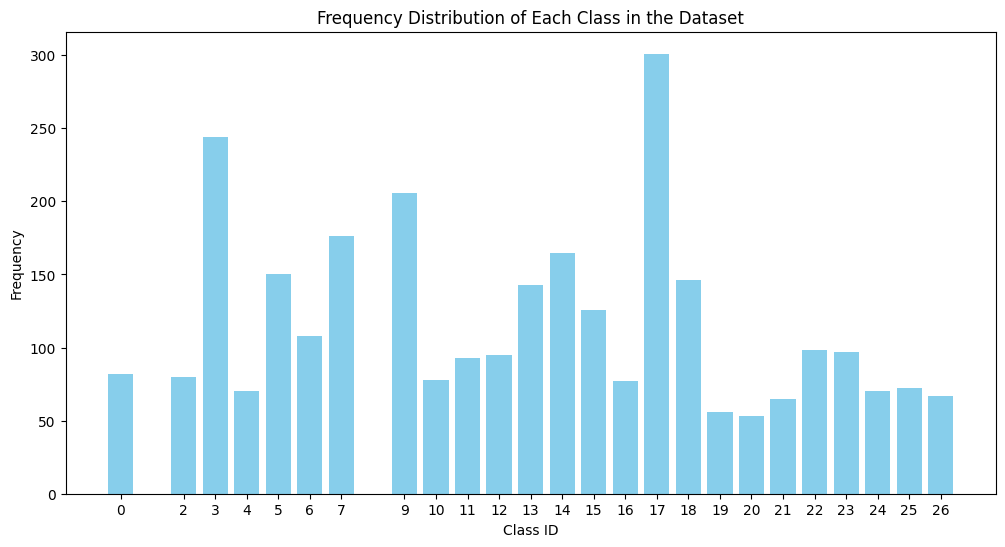

In [21]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Paths to the directories containing label files
base_dir = 'yolo_taco_recycling'  # Update this path to your dataset's base directory
label_dirs = [os.path.join(base_dir, split, 'labels') for split in ['train', 'val', 'test']]

# Initialize a counter for class frequencies
class_counts = Counter()

# Traverse each label directory (train, val, test)
for label_dir in label_dirs:
    if os.path.exists(label_dir):
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                label_path = os.path.join(label_dir, label_file)
                
                # Read the label file and count each class ID
                with open(label_path, 'r') as file:
                    for line in file:
                        class_id = int(line.split()[0])  # Get the class ID (first element in each line)
                        class_counts[class_id] += 1

# Sort the class counts by class ID for plotting
class_ids, frequencies = zip(*sorted(class_counts.items()))

# Plot the frequency distribution
plt.figure(figsize=(12, 6))
plt.bar(class_ids, frequencies, color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Each Class in the Dataset')
plt.xticks(class_ids)  # Show all class IDs on the x-axis
plt.show()

In [22]:
from ultralytics import YOLO

# Path to the YAML configuration file
data_yaml = 'taco.yaml'  # Update with the path to your taco.yaml file
model_type = 'yolov8s.pt'  # You can use other YOLOv8 models like yolov8s.pt, yolov8m.pt, etc.

# Load a pre-trained YOLOv8 model
model = YOLO(model_type)

100%|██████████| 21.5M/21.5M [00:00<00:00, 58.2MB/s]


In [24]:
# Train the model
model.train(
    data=data_yaml,
    epochs=100,
    imgsz=1024,
    batch=16,
    patience=15,
    freeze=10,
    augment=True# Freeze the first 10 layers
)

New https://pypi.org/project/ultralytics/8.3.28 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.27 🚀 Python-3.11.10 torch-2.5.1 CPU (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=taco.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=

train: Scanning /Users/andregraham/Library/Mobile Documents/com~apple~CloudDocs/University/George Brown/Semester II/Deep Learning II/Project/yolo_taco/train/labels.cache... 204 images, 100 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<?, ?it/s]
val: Scanning /Users/andregraham/Library/Mobile Documents/com~apple~CloudDocs/University/George Brown/Semester II/Deep Learning II/Project/yolo_taco/val/labels.cache... 126 images, 67 backgrounds, 0 corrupt: 100%|██████████| 126/126 [00:00<?, ?it/s]

Plotting labels to runs/detect/train7/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000323, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 0 dataloader workers
Logging results to runs/detect/train7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.086      19.56       1.33         23       1024: 100%|██████████| 13/13 [03:36<00:00, 16.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:19<00:57, 19.31s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:42<00:43, 21.68s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [01:01<00:20, 20.53s/it]

WARNING ⚠️ NMS time limit 3.500s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:20<00:00, 20.06s/it]

                   all        126        108          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      0.908      9.822      1.178         13       1024: 100%|██████████| 13/13 [03:34<00:00, 16.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:19<00:57, 19.01s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:42<00:42, 21.50s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [01:01<00:20, 20.60s/it]

WARNING ⚠️ NMS time limit 3.500s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:20<00:00, 20.06s/it]

                   all        126        108    0.00405     0.0081    0.00224    0.00119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G     0.8628      7.557      1.153         32       1024: 100%|██████████| 13/13 [03:34<00:00, 16.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:18<00:54, 18.26s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:16<00:00, 19.18s/it]

                   all        126        108     0.0939      0.207     0.0157     0.0114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      4/100         0G      0.861      5.926      1.157         24       1024: 100%|██████████| 13/13 [03:33<00:00, 16.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:11<00:00, 17.86s/it]

                   all        126        108      0.342     0.0868     0.0259     0.0191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G     0.7961      5.418      1.121         10       1024: 100%|██████████| 13/13 [03:33<00:00, 16.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:07<00:00, 16.77s/it]

                   all        126        108      0.279      0.128     0.0576     0.0421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      6/100         0G     0.8324      4.638      1.161         10       1024: 100%|██████████| 13/13 [03:33<00:00, 16.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:06<00:00, 16.54s/it]

                   all        126        108      0.395      0.156     0.0735     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G     0.8112       4.31       1.12         22       1024: 100%|██████████| 13/13 [03:34<00:00, 16.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:05<00:00, 16.36s/it]

                   all        126        108      0.498      0.116      0.107     0.0821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.8322      3.688      1.087         22       1024: 100%|██████████| 13/13 [03:35<00:00, 16.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:05<00:00, 16.27s/it]

                   all        126        108      0.328     0.0947     0.0713     0.0554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      9/100         0G     0.8122      3.414      1.058         17       1024: 100%|██████████| 13/13 [03:33<00:00, 16.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.24s/it]

                   all        126        108      0.301      0.225      0.113       0.08

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     10/100         0G     0.7386      2.843      1.044         23       1024: 100%|██████████| 13/13 [03:34<00:00, 16.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.14s/it]

                   all        126        108      0.208      0.176      0.111     0.0785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     11/100         0G     0.7015      2.489      1.042         22       1024: 100%|██████████| 13/13 [03:35<00:00, 16.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:05<00:00, 16.27s/it]

                   all        126        108      0.203      0.234       0.11     0.0823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     12/100         0G     0.7277      2.364      1.116         22       1024: 100%|██████████| 13/13 [03:33<00:00, 16.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.23s/it]

                   all        126        108      0.318       0.13      0.101     0.0758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     13/100         0G     0.7658       2.27      1.063         22       1024: 100%|██████████| 13/13 [03:33<00:00, 16.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.14s/it]

                   all        126        108      0.352      0.154      0.107     0.0771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     14/100         0G     0.7198      2.179      1.049         22       1024: 100%|██████████| 13/13 [03:33<00:00, 16.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.23s/it]

                   all        126        108       0.24      0.172      0.126     0.0791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     15/100         0G     0.7138       2.12      1.023         16       1024: 100%|██████████| 13/13 [03:35<00:00, 16.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.18s/it]

                   all        126        108      0.273      0.137      0.103     0.0735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     16/100         0G     0.7242      1.865      1.037         23       1024: 100%|██████████| 13/13 [03:35<00:00, 16.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.22s/it]

                   all        126        108      0.429      0.156       0.13     0.0936

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     17/100         0G     0.6832       1.65      1.035         37       1024: 100%|██████████| 13/13 [03:33<00:00, 16.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.21s/it]

                   all        126        108       0.45      0.165      0.147       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     18/100         0G     0.6727      1.533     0.9942         18       1024: 100%|██████████| 13/13 [03:35<00:00, 16.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:05<00:00, 16.30s/it]

                   all        126        108      0.428      0.142      0.161      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.7174      1.778      1.014         23       1024: 100%|██████████| 13/13 [03:34<00:00, 16.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.21s/it]

                   all        126        108      0.348      0.105      0.101     0.0746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     20/100         0G     0.6775      1.421       1.06         14       1024: 100%|██████████| 13/13 [03:34<00:00, 16.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.23s/it]

                   all        126        108       0.27      0.157     0.0984     0.0681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     21/100         0G      0.652      1.346      0.999         21       1024: 100%|██████████| 13/13 [03:35<00:00, 16.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.18s/it]

                   all        126        108       0.37       0.15      0.136     0.0992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     22/100         0G     0.6907      1.394      1.024         13       1024: 100%|██████████| 13/13 [03:35<00:00, 16.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.22s/it]

                   all        126        108      0.282      0.161      0.138      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     23/100         0G      0.674      1.331     0.9675         25       1024: 100%|██████████| 13/13 [03:34<00:00, 16.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.13s/it]

                   all        126        108      0.192       0.13      0.116     0.0781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     24/100         0G     0.6834      1.412      1.051          9       1024: 100%|██████████| 13/13 [03:34<00:00, 16.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.25s/it]

                   all        126        108      0.264       0.18      0.108     0.0739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     25/100         0G     0.6463      1.229     0.9859         22       1024: 100%|██████████| 13/13 [03:35<00:00, 16.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.22s/it]

                   all        126        108      0.259      0.169      0.108      0.074

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     26/100         0G     0.7092      1.303      1.007         21       1024: 100%|██████████| 13/13 [03:34<00:00, 16.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.24s/it]

                   all        126        108      0.191      0.181      0.109     0.0768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     27/100         0G     0.6561      1.141      1.019         19       1024: 100%|██████████| 13/13 [03:33<00:00, 16.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:05<00:00, 16.26s/it]

                   all        126        108      0.384      0.152      0.123     0.0916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     28/100         0G     0.5986      1.075     0.9317         11       1024: 100%|██████████| 13/13 [03:34<00:00, 16.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.17s/it]

                   all        126        108      0.476      0.158      0.148      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     29/100         0G     0.6731      1.068     0.9911         24       1024: 100%|██████████| 13/13 [03:35<00:00, 16.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.25s/it]

                   all        126        108       0.37      0.157       0.13     0.0974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     30/100         0G     0.6027      1.021     0.9627         13       1024: 100%|██████████| 13/13 [03:33<00:00, 16.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:05<00:00, 16.26s/it]

                   all        126        108      0.368      0.163        0.1     0.0767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     31/100         0G     0.6133      1.088     0.9894         15       1024: 100%|██████████| 13/13 [03:34<00:00, 16.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.18s/it]

                   all        126        108      0.243      0.145     0.0921     0.0684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     32/100         0G     0.5649     0.9619     0.9254         20       1024: 100%|██████████| 13/13 [03:35<00:00, 16.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:05<00:00, 16.29s/it]

                   all        126        108      0.484      0.107      0.143     0.0994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     33/100         0G     0.6068      1.011     0.9717          9       1024: 100%|██████████| 13/13 [03:33<00:00, 16.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:04<00:00, 16.22s/it]

                   all        126        108      0.508       0.12      0.139     0.0962
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 18, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

33 epochs completed in 2.579 hours.


Optimizer stripped from runs/detect/train7/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 22.6MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.11.10 torch-2.5.1 CPU (Apple M3 Pro)
Model summary (fused): 168 layers, 11,136,033 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:12<00:00, 33.06s/it]


                   all        126        108      0.309      0.207      0.143       0.11
        Aluminium foil          2          3          0          0          0          0
   Carded blister pack          9         11          1          0          0          0
  Other plastic bottle         12         18      0.107      0.667       0.39       0.33
  Clear plastic bottle         10         16      0.243      0.125      0.149      0.116
          Glass bottle         13         15       0.26      0.333      0.217      0.102
    Plastic bottle cap          4          7      0.393      0.143       0.19      0.145
      Metal bottle cap          2          2      0.185        0.5       0.11      0.107
              Food can         16         19      0.259      0.474       0.28      0.207
            Egg carton          4          6       0.57      0.449      0.434       0.35
     Corrugated carton          1          1          0          0    0.00152   0.000303
             Paper cu

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x35ebd73d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045, 